# Using vtreat with Regression Problems

Nina Zumel and John Mount
September 2019

Note: this is a description of the [`Python` version of `vtreat`](https://github.com/WinVector/pyvtreat), the same example for the [`R` version of `vtreat`](https://github.com/WinVector/vtreat) can be found [here](https://github.com/WinVector/vtreat/blob/master/Examples/Regression/Regression.md).



## Preliminaries

Load modules/packages.

In [1]:
import pkg_resources
import pandas
import numpy
import numpy.random
import seaborn
import matplotlib.pyplot as plt
import matplotlib.pyplot
import vtreat
import vtreat.util
import wvpy.util

Generate example data. 

* `y` is a noisy sinusoidal plus linear function of the variable `x`, and is the output to be predicted
* Input `xc` is a categorical variable that represents a discretization of `y`, along with some `NaN`s
* Input `x2` is a pure noise variable with no relationship to the output

In [2]:
def make_data(nrows):
    d = pandas.DataFrame({'x': 5*numpy.random.normal(size=nrows)})
    d['y'] = numpy.sin(d['x']) + 0.01*d['x'] + 0.1*numpy.random.normal(size=nrows)
    d.loc[numpy.arange(3, 10), 'x'] = numpy.nan                           # introduce a nan level
    d['xc'] = ['level_' + str(5*numpy.round(yi/5, 1)) for yi in d['y']]
    d['x2'] = numpy.random.normal(size=nrows)
    d.loc[d['xc']=='level_-1.0', 'xc'] = numpy.nan  # introduce a nan level
    return d

d = make_data(500)

d.head()

,x,y,xc,x2
0,-0.337517,-0.485065,level_-0.5,-0.841763
1,5.852095,-0.317856,level_-0.5,-0.179403
2,-0.753423,-0.716042,level_-0.5,0.766086
3,NaN,-0.634158,level_-0.5,-1.987960
4,NaN,0.608787,level_0.5,-0.031149


### Some quick data exploration

Check how many levels `xc` has, and their distribution (including `NaN`)

In [3]:
d['xc'].unique()

array(['level_-0.5', 'level_0.5', 'level_1.0', nan, 'level_0.0',
       'level_-0.0'], dtype=object)

In [4]:
d['xc'].value_counts(dropna=False)

NaN           124
level_1.0     104
level_0.5     103
level_-0.5     76
level_-0.0     50
level_0.0      43
Name: xc, dtype: int64

Find the mean value of `y`

In [5]:
numpy.mean(d['y'])

-0.010085215726766392

Plot of `y` versus `x`.

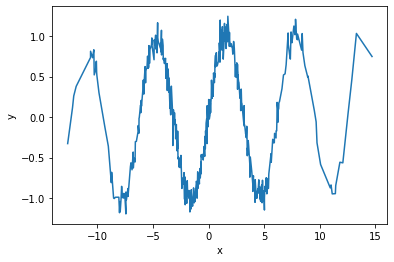

In [6]:
seaborn.lineplot(x='x', y='y', data=d)

## Build a transform appropriate for regression problems.

Now that we have the data, we want to treat it prior to modeling: we want training data where all the input variables are numeric and have no missing values or `NaN`s.

First create the data treatment transform object, in this case a treatment for a regression problem.

In [7]:
transform = vtreat.NumericOutcomeTreatment(
    outcome_name='y',    # outcome variable
)  

Notice that for the training data `d`: `transform_design$crossFrame` is **not** the same as `transform.prepare(d)`; the second call can lead to nested model bias in some situations, and is **not** recommended.
For other, later data, not seen during transform design `transform.preprare(o)` is an appropriate step.

Use the training data `d` to fit the transform and the return a treated training set: completely numeric, with no missing values.

In [8]:
d_prepared = transform.fit_transform(d, d['y'])

Now examine the score frame, which gives information about each new variable, including its type, which original variable it is  derived from, its (cross-validated) correlation with the outcome, and its (cross-validated) significance as a one-variable linear model for the outcome. 

In [9]:
transform.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,default_threshold,recommended
0,x_is_bad,x,missing_indicator,False,True,0.034137,4.462734e-01,2.0,0.083333,False
1,xc_is_bad,xc,missing_indicator,False,True,-0.744392,2.168242e-89,2.0,0.083333,True
2,x,x,clean_copy,False,True,-0.000047,9.991706e-01,2.0,0.083333,False
3,x2,x2,clean_copy,False,True,-0.057059,2.027654e-01,2.0,0.083333,False
4,xc_impact_code,xc,impact_code,True,True,0.986627,0.000000e+00,1.0,0.166667,True
5,xc_deviation_code,xc,deviation_code,True,True,0.216944,9.715902e-07,1.0,0.166667,True
6,xc_prevalence_code,xc,prevalence_code,False,True,-0.139163,1.813520e-03,1.0,0.166667,True
7,xc_lev__NA_,xc,indicator_code,False,True,-0.744392,2.168242e-89,5.0,0.033333,True
8,xc_lev_level_1.0,xc,indicator_code,False,True,0.679712,4.818757e-69,5.0,0.033333,True
9,xc_lev_level_0.5,xc,indicator_code,False,True,0.374366,4.424507e-18,5.0,0.033333,True


Note that the variable `xc` has been converted to multiple variables: 

* an indicator variable for each common possible level (`xc_lev_level_*`)
* the value of a (cross-validated) one-variable model for `y` as a function of `xc` (`xc_impact_code`)
* a variable indicating when `xc` was `NaN` in the original data (`xc_is_bad`)
* a variable that returns how prevalent this particular value of `xc` is in the training data (`xc_prevalence_code`)
* a variable that returns standard deviation of `y` conditioned on `xc` (`xc_deviation_code`)

Any or all of these new variables are available for downstream modeling.

The `recommended` column indicates which variables are non constant (`has_range` == True) and have a significance value smaller than `default_threshold`. See the section *Deriving the Default Thresholds* below for the reasoning behind the default thresholds. Recommended columns are intended as advice about which variables appear to be most likely to be useful in a downstream model. This advice attempts to be conservative, to reduce the possibility of mistakenly eliminating variables that may in fact be useful (although, obviously, it can still mistakenly eliminate variables that have a real but non-linear relationship to the output).

Let's look at the recommended and not recommended variables:

In [10]:
# recommended variables
transform.score_frame_['variable'][transform.score_frame_['recommended']]

1              xc_is_bad
4         xc_impact_code
5      xc_deviation_code
6     xc_prevalence_code
7            xc_lev__NA_
8       xc_lev_level_1.0
9       xc_lev_level_0.5
10     xc_lev_level_-0.5
Name: variable, dtype: object

In [11]:
# not recommended variables
transform.score_frame_['variable'][transform.score_frame_['recommended']==False]

0              x_is_bad
2                     x
3                    x2
11    xc_lev_level_-0.0
Name: variable, dtype: object

Let's look at the top of `d_prepared`. Notice that the new treated data frame included only recommended variables (along with `y`).

In [12]:
d_prepared.head()

,y,xc_is_bad,xc_impact_code,xc_deviation_code,xc_prevalence_code,xc_lev__NA_,xc_lev_level_1.0,xc_lev_level_0.5,xc_lev_level_-0.5
0,-0.485065,0.0,-0.506594,0.145772,0.152,0.0,0.0,0.0,1.0
1,-0.317856,0.0,-0.492048,0.148191,0.152,0.0,0.0,0.0,1.0
2,-0.716042,0.0,-0.492048,0.148191,0.152,0.0,0.0,0.0,1.0
3,-0.634158,0.0,-0.494071,0.149066,0.152,0.0,0.0,0.0,1.0
4,0.608787,0.0,0.534380,0.142892,0.206,0.0,0.0,1.0,0.0


This is `vtreat`'s default behavior; to include all variables in the prepared data, set the parameter `filter_to_recommended` to False, as we show later, in the *Parameters for `NumericOutcomeTreatment`* section below.

## A Closer Look at the `impact_code` variables

Variables of type `impact_code` are the outputs of a one-variable hierarchical linear regression of a categorical variable (in our example, `xc`) against the centered output on the (cross-validated) treated training data. 

Let's look at the relationship between `xc_impact_code` and `y` (actually `y_centered`, a centered version of `y`). 

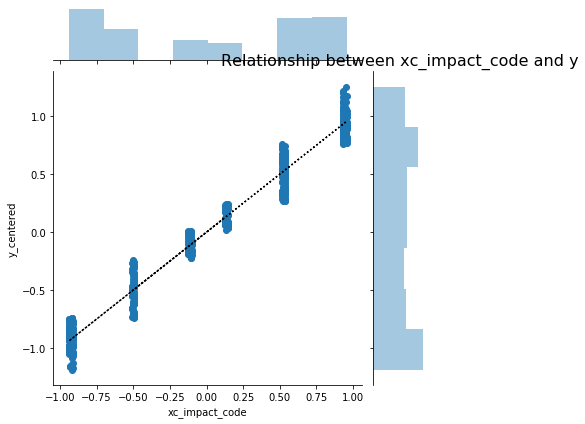

In [13]:
d_prepared['y_centered'] = d_prepared.y - d_prepared.y.mean()

g = seaborn.jointplot("xc_impact_code", "y_centered", d_prepared, kind="scatter")
# add the line "x = y"
g.ax_joint.plot(d_prepared.xc_impact_code, d_prepared.xc_impact_code, ':k')
plt.title('Relationship between xc_impact_code and y', fontsize = 16)
plt.show()

This indicates that `xc_impact_code` is strongly predictive of the outcome. Note that the score frame also reported the Pearson correlation between `xc_impact_code` and `y`, which is fairly large.

In [14]:
transform.score_frame_.PearsonR[transform.score_frame_.variable=='xc_impact_code']

4    0.986627
Name: PearsonR, dtype: float64

Note also that the impact code values are jittered; this is because `d_prepared` is a "cross-frame": that is, the result of a cross-validated estimation process. Hence, the impact coding of `xc` is a function of both the value of `xc` and the cross-validation fold of the datum's row. When `transform` is applied to new data, there will be only one value of impact code for each (common) level of `xc`. We can see this by applying the transform to the data frame `d` as if it were new data.


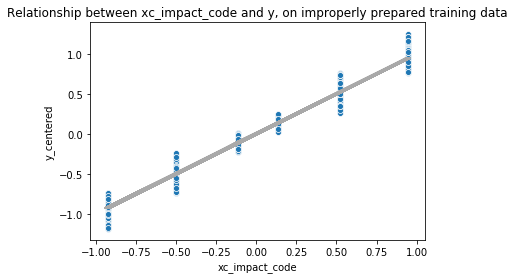

In [15]:
dtmp = transform.transform(d)
dtmp['y_centered'] = dtmp.y - dtmp.y.mean()
ax = seaborn.scatterplot(x = 'xc_impact_code', y = 'y_centered', data = dtmp)
# add the line "x = y"
matplotlib.pyplot.plot(d_prepared.xc_impact_code, dtmp.xc_impact_code, color="darkgray")
ax.set_title('Relationship between xc_impact_code and y, on improperly prepared training data')
plt.show()

Variables of type `impact_code` are useful when dealing with categorical variables with a very large number of possible levels. For example, a categorical variable with 10,000 possible values potentially converts to 10,000 indicator variables, which may be unwieldy for some modeling methods. Using a single numerical variable of type `impact_code` may be a preferable alternative.

## Using the Prepared Data in a Model

Of course, what we really want to do with the prepared training data is to fit a model jointly with all the (recommended) variables. 
Let's try fitting a linear regression model to `d_prepared`.

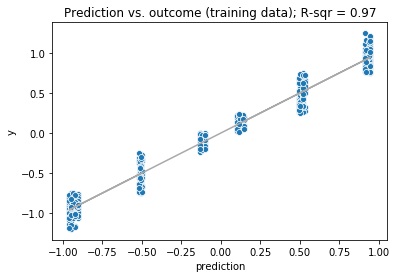

In [16]:
import sklearn.linear_model
import seaborn
import sklearn.metrics

not_variables = ['y', 'y_centered', 'prediction']
model_vars = [v for v in d_prepared.columns if v not in set(not_variables)]

fitter = sklearn.linear_model.LinearRegression()
fitter.fit(d_prepared[model_vars], d_prepared['y'])

# now predict
d_prepared['prediction'] = fitter.predict(d_prepared[model_vars])

# get R-squared
r2 = sklearn.metrics.r2_score(y_true=d_prepared.y, y_pred=d_prepared.prediction)

title = 'Prediction vs. outcome (training data); R-sqr = {:04.2f}'.format(r2)

# compare the predictions to the outcome (on the training data)
ax = seaborn.scatterplot(x='prediction', y='y', data=d_prepared)
matplotlib.pyplot.plot(d_prepared.prediction, d_prepared.prediction, color="darkgray")
ax.set_title(title)
plt.show()

Now apply the model to new data.

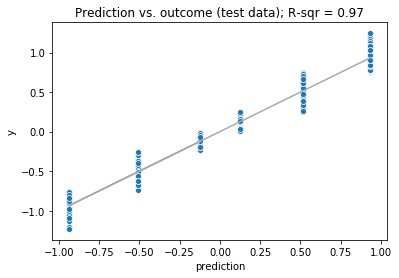

In [17]:
# create the new data
dtest = make_data(450)

# prepare the new data with vtreat
dtest_prepared = transform.transform(dtest)

# apply the model to the prepared data
dtest_prepared['prediction'] = fitter.predict(dtest_prepared[model_vars])

# get R-squared
r2 = sklearn.metrics.r2_score(y_true=dtest_prepared.y, y_pred=dtest_prepared.prediction)

title = 'Prediction vs. outcome (test data); R-sqr = {:04.2f}'.format(r2)

# compare the predictions to the outcome (on the test data)
ax = seaborn.scatterplot(x='prediction', y='y', data=dtest_prepared)
matplotlib.pyplot.plot(dtest_prepared.prediction, dtest_prepared.prediction, color="darkgray")
ax.set_title(title)
plt.show()

## Parameters for `NumericOutcomeTreatment`

We've tried to set the defaults for all parameters so that `vtreat` is usable out of the box for most applications.


In [18]:
vtreat.vtreat_parameters()

{'use_hierarchical_estimate': True,
 'coders': {'clean_copy',
  'deviation_code',
  'impact_code',
  'indicator_code',
  'logit_code',
  'missing_indicator',
  'prevalence_code'},
 'filter_to_recommended': True,
 'indicator_min_fraction': 0.1,
 'cross_validation_plan': <vtreat.cross_plan.KWayCrossPlan at 0x1a1c26d5f8>,
 'cross_validation_k': 5,
 'user_transforms': [],
 'sparse_indicators': True}

**use_hierarchical_estimate:**: When True, uses hierarchical smoothing when estimating `impact_code` variables; when False, uses unsmoothed linear regression.

**coders**: The types of synthetic variables that `vtreat` will (potentially) produce. See *Types of prepared variables* below.

**filter_to_recommended**: When True, prepared data only includes variables marked as "recommended" in score frame. When False, prepared data includes all variables. See the Example below.

**indicator_min_fraction**: For categorical variables, indicator variables (type `indicator_code`) are only produced for levels that are present at least `indicator_min_fraction` of the time. A consequence of this is that 1/`indicator_min_fraction` is the maximum number of indicators that will be produced for a given categorical variable. To make sure that *all* possible indicator variables are produced, set `indicator_min_fraction = 0`

**cross_validation_plan**: The cross validation method used by `vtreat`. Most people won't have to change this.

**cross_validation_k**: The number of folds to use for cross-validation

**user_transforms**: For passing in user-defined transforms for custom data preparation. Won't be needed in most situations, but see [here](https://github.com/WinVector/pyvtreat/blob/master/Examples/UserCoders/UserCoders.ipynb) for an example of applying a GAM transform to input variables.

**sparse_indicators**: When True, use a (Pandas) sparse representation for indicator variables. This representation is compatible with `sklearn`; however, it may not be compatible with other modeling packages. When False, use a dense representation.

### Example: Use all variables to model, not just recommended

In [19]:
transform_all = vtreat.NumericOutcomeTreatment(
    outcome_name='y',    # outcome variable
    params = vtreat.vtreat_parameters({
        'filter_to_recommended': False
    })
)  

transform_all.fit_transform(d, d['y']).columns

Index(['y', 'x_is_bad', 'xc_is_bad', 'x', 'x2', 'xc_impact_code',
       'xc_deviation_code', 'xc_prevalence_code', 'xc_lev__NA_',
       'xc_lev_level_1.0', 'xc_lev_level_0.5', 'xc_lev_level_-0.5',
       'xc_lev_level_-0.0'],
      dtype='object')

In [20]:
transform_all.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,default_threshold,recommended
0,x_is_bad,x,missing_indicator,False,True,0.034137,4.462734e-01,2.0,0.083333,False
1,xc_is_bad,xc,missing_indicator,False,True,-0.744392,2.168242e-89,2.0,0.083333,True
2,x,x,clean_copy,False,True,-0.000047,9.991706e-01,2.0,0.083333,False
3,x2,x2,clean_copy,False,True,-0.057059,2.027654e-01,2.0,0.083333,False
4,xc_impact_code,xc,impact_code,True,True,0.986486,0.000000e+00,1.0,0.166667,True
5,xc_deviation_code,xc,deviation_code,True,True,0.230634,1.841149e-07,1.0,0.166667,True
6,xc_prevalence_code,xc,prevalence_code,False,True,-0.139163,1.813520e-03,1.0,0.166667,True
7,xc_lev__NA_,xc,indicator_code,False,True,-0.744392,2.168242e-89,5.0,0.033333,True
8,xc_lev_level_1.0,xc,indicator_code,False,True,0.679712,4.818757e-69,5.0,0.033333,True
9,xc_lev_level_0.5,xc,indicator_code,False,True,0.374366,4.424507e-18,5.0,0.033333,True


Note that the prepared data produced by `fit_transform()` includes all the variables, including those that were not marked as "recommended". 

## Types of prepared variables

**clean_copy**: Produced from numerical variables: a clean numerical variable with no `NaNs` or missing values

**indicator_code**: Produced from categorical variables, one for each (common) level: for each level of the variable, indicates if that level was "on"

**prevalence_code**: Produced from categorical variables: indicates how often each level of the variable was "on"

**deviation_code**: Produced from categorical variables: standard deviation of outcome conditioned on levels of the variable

**impact_code**: Produced from categorical variables: score from a one-dimensional model of the output as a function of the variable

**missing_indicator**: Produced for both numerical and categorical variables: an indicator variable that marks when the original variable was missing or  `NaN`

**logit_code**: not used by `NumericOutcomeTreatment`

### Example: Produce only a subset of variable types

In this example, suppose you only want to use indicators and continuous variables in your model; 
in other words, you only want to use variables of types (`clean_copy`, `missing_indicator`, and `indicator_code`), and no `impact_code`, `deviance_code`, or `prevalence_code` variables.

In [21]:
transform_thin = vtreat.NumericOutcomeTreatment(
    outcome_name='y',    # outcome variable
    params = vtreat.vtreat_parameters({
        'filter_to_recommended': False,
        'coders': {'clean_copy',
                   'missing_indicator',
                   'indicator_code',
                  }
    })
)

transform_thin.fit_transform(d, d['y']).head()

,y,x_is_bad,xc_is_bad,x,x2,xc_lev__NA_,xc_lev_level_1.0,xc_lev_level_0.5,xc_lev_level_-0.5,xc_lev_level_-0.0
0,-0.485065,0.0,0.0,-0.337517,-0.841763,0.0,0.0,0.0,1.0,0.0
1,-0.317856,0.0,0.0,5.852095,-0.179403,0.0,0.0,0.0,1.0,0.0
2,-0.716042,0.0,0.0,-0.753423,0.766086,0.0,0.0,0.0,1.0,0.0
3,-0.634158,1.0,0.0,-0.146499,-1.987960,0.0,0.0,0.0,1.0,0.0
4,0.608787,1.0,0.0,-0.146499,-0.031149,0.0,0.0,1.0,0.0,0.0


In [22]:
transform_thin.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,default_threshold,recommended
0,x_is_bad,x,missing_indicator,False,True,0.034137,4.462734e-01,2.0,0.166667,False
1,xc_is_bad,xc,missing_indicator,False,True,-0.744392,2.168242e-89,2.0,0.166667,True
2,x,x,clean_copy,False,True,-0.000047,9.991706e-01,2.0,0.166667,False
3,x2,x2,clean_copy,False,True,-0.057059,2.027654e-01,2.0,0.166667,False
4,xc_lev__NA_,xc,indicator_code,False,True,-0.744392,2.168242e-89,5.0,0.066667,True
5,xc_lev_level_1.0,xc,indicator_code,False,True,0.679712,4.818757e-69,5.0,0.066667,True
6,xc_lev_level_0.5,xc,indicator_code,False,True,0.374366,4.424507e-18,5.0,0.066667,True
7,xc_lev_level_-0.5,xc,indicator_code,False,True,-0.296941,1.230219e-11,5.0,0.066667,True
8,xc_lev_level_-0.0,xc,indicator_code,False,True,-0.051819,2.474433e-01,5.0,0.066667,False


## Deriving the Default Thresholds

While machine learning algorithms are generally tolerant to a reasonable number of irrelevant or noise variables, too many irrelevant variables can lead to serious overfit; see [this article](http://www.win-vector.com/blog/2014/02/bad-bayes-an-example-of-why-you-need-hold-out-testing/) for an extreme example, one we call "Bad Bayes". The default threshold is an attempt to eliminate obviously irrelevant variables early.

Imagine that you have a pure noise dataset, where none of the *n* inputs are related to the output. If you treat each variable as a one-variable model for the output, and look at the significances of each model, these significance-values will be uniformly distributed in the range [0:1]. You want to pick a weakest possible significance threshold that eliminates as many noise variables as possible. A moment's thought should convince you that a threshold of *1/n* allows only one variable through, in expectation. 

This leads to the general-case heuristic that a significance threshold of *1/n* on your variables should allow only one irrelevant variable through, in expectation (along with all the relevant variables). Hence, *1/n* used to be our recommended threshold, when we developed the R version of `vtreat`.

We noticed, however, that this biases the filtering against numerical variables, since there are at most two derived variables (of types *clean_copy* and *missing_indicator* for every numerical variable in the original data. Categorical variables, on the other hand, are expanded to many derived variables: several indicators (one for every common level), plus a *logit_code* and a *prevalence_code*. So we now reweight the thresholds. 

Suppose you have a (treated) data set with *ntreat* different types of `vtreat` variables (`clean_copy`, `indicator_code`, etc).
There are *nT* variables of type *T*. Then the default threshold for all the variables of type *T* is *1/(ntreat nT)*. This reweighting  helps to reduce the bias against any particular type of variable. The heuristic is still that the set of recommended variables will allow at most one noise variable into the set of candidate variables.

As noted above, because `vtreat` estimates variable significances using linear methods by default, some variables with a non-linear relationship  to the output may fail to pass the threshold. Setting the `filter_to_recommended` parameter to False will keep all derived variables in the treated frame, for the data scientist to filter (or not) as they will.


## Conclusion

In all cases (classification, regression, unsupervised, and multinomial classification) the intent is that `vtreat` transforms are essentially one liners.

The preparation commands are organized as follows:

 * **Regression**: [`R` regression example](https://github.com/WinVector/vtreat/blob/master/Examples/Regression/Regression.md), [`Python` regression example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Regression/Regression.md).
 * **Classification**: [`R` classification example](https://github.com/WinVector/vtreat/blob/master/Examples/Classification/Classification.md), [`Python` classification  example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Classification/Classification.md).
 * **Unsupervised tasks**: [`R` unsupervised example](https://github.com/WinVector/vtreat/blob/master/Examples/Unsupervised/Unsupervised.md), [`Python` unsupervised example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Unsupervised/Unsupervised.md).
 * **Multinomial classification**: [`R` multinomial classification example](https://winvector.github.io/vtreat/articles/MultiClassVtreat.html), [`Python` multinomial classification example](https://github.com/WinVector/pyvtreat/blob/master/Examples/Multinomial/MultinomialExample.ipynb).

These current revisions of the examples are designed to be small, yet complete.  So as a set they have some overlap, but the user can rely mostly on a single example for a single task type.

